# Technical Assesment
Author: [Sébastien Lozano Forero](https://www.linkedin.com/in/sebastienlozanoforero/)

April, 2022. 

This project is based on an technical assessment used by a Colombian bank to fill the position of Data Scientist. Data was modified shared in a modified version not containing any identification information. Currency within this project is set to Colombian pesos. 

# Loading libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
import xgboost as xgb

from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from pandas_profiling import ProfileReport


from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import datasets, metrics, model_selection, svm
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
# from boruta import BorutaPy

# Data Loading

In [3]:
data = pd.read_csv('Base_campana_DC.csv',encoding = "ISO-8859-1", sep =';',parse_dates=['fecha_ult_desembolso'], 
                  dtype = {
                      'Id_Cliente':str,
                      'Ciudad':str,
                      ' Patrimonio ':int,
                      ' Ingresos_Mensuales ':int,
                      'No_hijos':int,
                      'oficina':str,
                      'monto_credito':int,
                      'tasa':float,
                      'saldo_capital':int,
                      'Antiguedad_en_meses':int,
                      'Max_dias_mora':int,
                      'plazo_dias':int,
                      'Edad':int,
                      'Acepta_Campaña':str,
                  })


## Checking variables names

In [4]:
data.columns

Index(['Id_Cliente', 'Ciudad', ' Patrimonio ', ' Ingresos_Mensuales ',
       'No_hijos', 'oficina', 'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'Acepta_Campaña'],
      dtype='object')

In [5]:
data = data.rename(columns = {' Ingresos_Mensuales ':'Ingresos_Mensuales',
                              ' Patrimonio ':'Patrimonio'})

## Chequing Data types

In [6]:
data.dtypes

Id_Cliente                      object
Ciudad                          object
Patrimonio                       int32
Ingresos_Mensuales               int32
No_hijos                         int32
oficina                         object
fecha_ult_desembolso    datetime64[ns]
monto_credito                    int32
tasa                           float64
saldo_capital                    int32
saldo_Ahorro                     int64
Antiguedad_en_meses              int32
Max_dias_mora                    int32
plazo_dias                       int32
Edad                             int32
Acepta_Campaña                  object
dtype: object

# Exploratory and Descriptiva Analysis (EDA)

In [7]:
# prof = ProfileReport(data)
# prof.to_file(output_file='output.html')

In [8]:
num_attributes = data.select_dtypes( include=['int32', 'float64'] )
cat_attributes = data.select_dtypes( exclude=['int32', 'float64', 'datetime64[ns]'] )

In [9]:
# sns.pairplot(num_attributes)

In [10]:
data['mes_ult_desembolso'] = data['fecha_ult_desembolso'].dt.month
data['semana_ult_desembolso'] = data['fecha_ult_desembolso'].dt.weekofyear

C:\Users\Windows\AppData\Local\Temp/ipykernel_9512/1843789318.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  data['semana_ult_desembolso'] = data['fecha_ult_desembolso'].dt.weekofyear


## Data Filtering

In [11]:
data['No_hijos'].value_counts()

0    932
2    872
1    816
3      7
4      1
Name: No_hijos, dtype: int64

Queremos filtrar valores muy altos en ingresos o números de hijos (hay un cliente con ingresos de 26 millones al mes y cuatro hijos).

In [12]:
data = data[(data['Ingresos_Mensuales'] != data['Ingresos_Mensuales'].max())&
            (data['No_hijos'] <3)]

## Data preparation

In [13]:
data.columns

Index(['Id_Cliente', 'Ciudad', 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'oficina', 'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'Acepta_Campaña', 'mes_ult_desembolso',
       'semana_ult_desembolso'],
      dtype='object')

In [14]:
X = data[[ 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'mes_ult_desembolso']]
y  = data['Acepta_Campaña']

In [15]:
ciudad = pd.get_dummies(data['Ciudad'], prefix='C')

In [16]:
X= X.join(ciudad)

In [17]:
mms = MinMaxScaler()

X['Patrimonio'] = mms.fit_transform( X[['Patrimonio']].values )
X['Ingresos_Mensuales'] = mms.fit_transform( X[['Ingresos_Mensuales']].values )
X['No_hijos'] = mms.fit_transform( X[['No_hijos']].values )
X['fecha_ult_desembolso'] = mms.fit_transform( X[['fecha_ult_desembolso']].values )
X['monto_credito'] = mms.fit_transform( X[['monto_credito']].values )
X['tasa'] = mms.fit_transform( X[['tasa']].values )
X['saldo_capital'] = mms.fit_transform( X[['saldo_capital']].values )
X['saldo_Ahorro'] = mms.fit_transform( X[['saldo_Ahorro']].values )
X['Antiguedad_en_meses'] = mms.fit_transform( X[['Antiguedad_en_meses']].values )
X['Max_dias_mora'] = mms.fit_transform( X[['Max_dias_mora']].values )
X['Edad'] = mms.fit_transform( X[['Edad']].values )
X['plazo_dias'] = mms.fit_transform( X[['plazo_dias']].values )
X['mes_ult_desembolso'] = mms.fit_transform( X[['mes_ult_desembolso']].values )
# X['semana_ult_desembolso'] = mms.fit_transform( X[['semana_ult_desembolso']].values )

# Machine Learning model 

## Data Splitting

In [18]:
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Baseline Clasiffier

In [19]:
dummy_clf = DummyClassifier(random_state=42).fit(X_train, y_train)
y_pred_clf = dummy_clf.predict(X_test)

In [20]:
cf_matrix = confusion_matrix(y_test, y_pred_clf)

print(cf_matrix)

[[324   0]
 [331   0]]


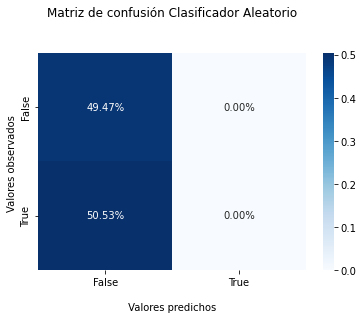

In [21]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Clasificador Aleatorio\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

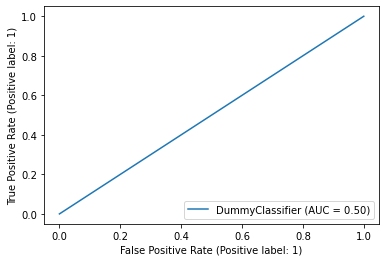

In [22]:
metrics.plot_roc_curve(dummy_clf, X_test, y_test) 

In [23]:
scores = cross_val_score(dummy_clf, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.50761421 0.50761421 0.50761421 0.50761421 0.51020408 0.51020408
 0.51020408 0.51020408 0.50510204 0.50510204]
Precisión de validación cruzada: 0.508 +/- 0.002


## k-nearest neighbors 


In [24]:
dummy_KNN = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
y_pred_knn = dummy_KNN.predict(X_test)

In [25]:
cf_matrix = confusion_matrix(y_test, y_pred_knn)

print(cf_matrix)

[[258  66]
 [ 70 261]]


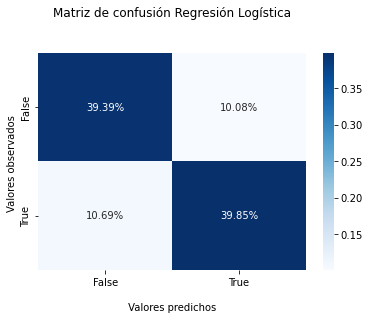

In [26]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Regresión Logística\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

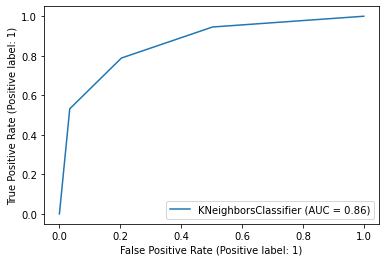

In [27]:
metrics.plot_roc_curve(dummy_KNN, X_test, y_test) 

In [28]:
scores = cross_val_score(dummy_KNN, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.79695431 0.76649746 0.79187817 0.79187817 0.75510204 0.75510204
 0.80612245 0.74489796 0.76020408 0.76530612]
Precisión de validación cruzada: 0.773 +/- 0.020


## Logistic Regression

In [29]:
reg_log = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred_reg_log = reg_log.predict(X_test)

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred_reg_log)

print(cf_matrix)

[[208 116]
 [130 201]]


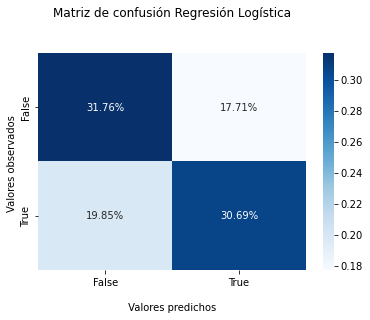

In [31]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Regresión Logística\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

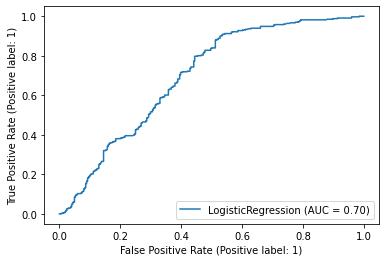

In [32]:
metrics.plot_roc_curve(reg_log, X_test, y_test) 

In [33]:
scores = cross_val_score(reg_log, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.69543147 0.65482234 0.63451777 0.65989848 0.62755102 0.69387755
 0.69387755 0.64285714 0.64285714 0.6122449 ]
Precisión de validación cruzada: 0.656 +/- 0.028


## Random Forest

In [34]:
rf =RandomForestClassifier(max_depth=2, random_state=0).fit( X_train, y_train )

# prediction
y_pred_rf = rf.predict( X_test)

In [35]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)

print(cf_matrix)

[[219 105]
 [ 84 247]]


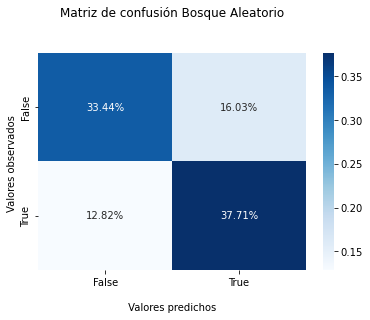

In [36]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Bosque Aleatorio\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

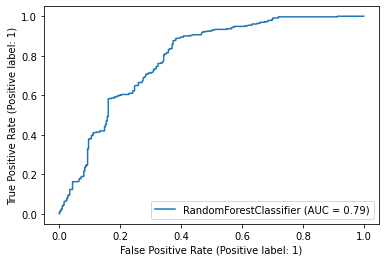

In [37]:
metrics.plot_roc_curve(rf, X_test, y_test) 

In [38]:
scores = cross_val_score(rf, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.73604061 0.70050761 0.73096447 0.69543147 0.73979592 0.71428571
 0.73979592 0.66836735 0.72959184 0.70408163]
Precisión de validación cruzada: 0.716 +/- 0.022


## Naive Bayes

In [39]:
nb =GaussianNB().fit( X_train, y_train )

# prediction
y_pred_NB = nb.predict( X_test)

In [40]:
cf_matrix = confusion_matrix(y_test, y_pred_NB)

print(cf_matrix)

[[196 128]
 [120 211]]


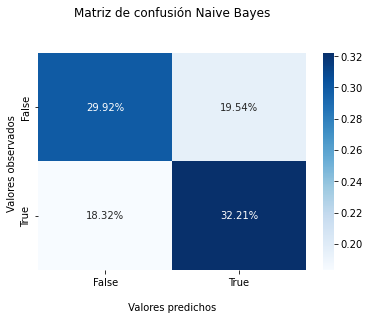

In [41]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión Naive Bayes\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

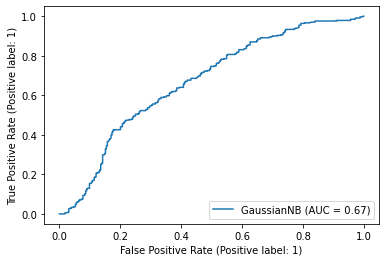

In [42]:
metrics.plot_roc_curve(nb, X_test, y_test) 

In [43]:
scores = cross_val_score(nb, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

Puntajes obtenidos: [0.66497462 0.59390863 0.62436548 0.65482234 0.60204082 0.66836735
 0.66326531 0.61734694 0.68367347 0.62755102]
Precisión de validación cruzada: 0.640 +/- 0.029


## XGBoost 

In [44]:
xgb_cl = xgb.XGBClassifier().fit( X_train, y_train )

y_pred_xgb = xgb_cl.predict(X_test)

[16:01:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [45]:
cf_matrix = confusion_matrix(y_test, y_pred_xgb)

print(cf_matrix)

[[284  40]
 [ 34 297]]


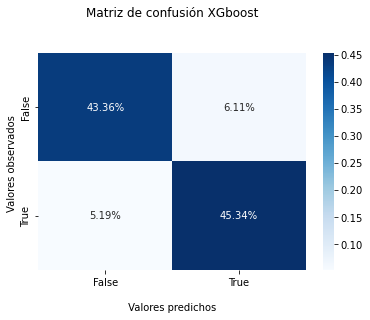

In [46]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión XGboost\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

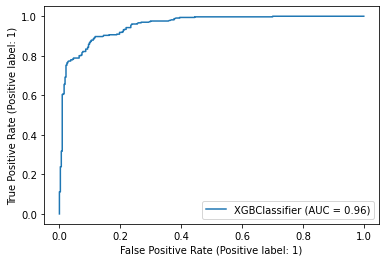

In [47]:
metrics.plot_roc_curve(xgb_cl, X_test, y_test) 

In [48]:
scores = cross_val_score(xgb_cl, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

[16:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Puntajes obtenidos: [0.88324873 0.79695431 0.83248731 0.88832487 0.87755102 0.86734694
 0.85714286 0.81122449 0.84183673 0.85204082]
Precisión de validación cruzada: 0.851 +/- 0.029


## Summary of results

In [49]:
scores_bln = cross_val_score(dummy_clf, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_knn = cross_val_score(dummy_KNN, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_log = cross_val_score(reg_log, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_rf = cross_val_score(rf, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_nb = cross_val_score(nb, X=X_train, y=y_train, cv=10, n_jobs=1)
scores_xgb = cross_val_score(xgb_cl, X=X_train, y=y_train, cv=10, n_jobs=1)


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Windows\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:01:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [50]:
res_baseline = pd.DataFrame( {'Model Name': 'Baseline', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_bln),np.std(scores_bln))},index=[0] ) 
res_KNN = pd.DataFrame( {'Model Name': 'KNN', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_knn),np.std(scores_knn))},index=[0] ) 
res_lr = pd.DataFrame( {'Model Name': 'Logistic Regression',
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_log),np.std(scores_log))},index=[0] ) 
res_rf = pd.DataFrame( {'Model Name': 'Random Forest',
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_rf),np.std(scores_rf))},index=[0] ) 
res_nb = pd.DataFrame( {'Model Name': 'Naive Bayes', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_nb),np.std(scores_nb))},index=[0] ) 
res_xgb = pd.DataFrame( {'Model Name': 'XGBoost', 
                'Accuracy':  '%.3f +/- %.3f' % (np.mean(scores_xgb),np.std(scores_xgb))},index=[0] )
Accuracy = pd.concat([res_baseline,res_KNN,res_lr,res_rf,res_nb,res_xgb])

In [51]:
Accuracy.sort_values('Accuracy', ascending = False)

,Model Name,Accuracy
0,XGBoost,0.851 +/- 0.029
0,KNN,0.773 +/- 0.020
0,Random Forest,0.716 +/- 0.022
0,Logistic Regression,0.656 +/- 0.028
0,Naive Bayes,0.640 +/- 0.029
0,Baseline,0.508 +/- 0.002


Thus, the model XGboost is going to be selected for forecasting. But first, let see if a better version if achivable by means of an hyperparameter tuning process

## Model Hyperparameter Tuning

In [ ]:
dtrain = xgb.DMatrix(X_test, label=y_test)

def bo_tune_xgb(max_depth, gamma, n_estimators ,learning_rate):
    params = {'max_depth': int(max_depth),
                'gamma': gamma,
              'n_estimators': int(n_estimators),
              'learning_rate':learning_rate,
              'subsample': 0.8,
              'eta': 0.1,
              'eval_metric': 'rmse'}
    #Cross validating with the specified parameters in 5 folds and 70 iterations
    cv_result = xgb.cv(params, dtrain, num_boost_round=70, nfold=5)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]


In [ ]:
#Invoking the Bayesian Optimizer with the specified parameters to tune
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (3, 10),
                                            'gamma': (0, 1),
                                            'learning_rate':(0,1),
                                             'n_estimators':(100,120)})

In [ ]:
xgb_bo.maximize(n_iter=5, init_points=8, acq='ei')

In [ ]:
#Extracting the best parameters
params = xgb_bo.max['params']
print(params)

In [ ]:
#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

#Initialize an XGBClassifier with the tuned parameters and fit the training data

classifier2 = XGBClassifier(**params).fit(X_test, y_test)

In [ ]:
y_pred_xgb_param = classifier2.predict(X_test)

In [ ]:
cf_matrix = confusion_matrix(y_test, y_pred_xgb_param)

print(cf_matrix)

In [ ]:
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Matriz de confusión XGboost\n\n');
ax.set_xlabel('\n Valores predichos ')
ax.set_ylabel('Valores observados ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
metrics.plot_roc_curve(classifier2, X_test, y_test) 

In [ ]:
scores = cross_val_score(classifier2, X=X_train, y=y_train, cv=10, n_jobs=1)
 
print('Puntajes obtenidos: %s' % scores)
print('Precisión de validación cruzada: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

## Using the model to predict new data

In [ ]:
nueva = pd.read_csv('Base_nueva_DC.csv',encoding = "ISO-8859-1", sep =';',parse_dates=['fecha_ult_desembolso'], 
                  dtype = {
                      'Id_Cliente':str,
                      'Ciudad':str,
                      ' Patrimonio ':int,
                      ' Ingresos_Mensuales ':int,
                      'No_hijos':int,
                      'oficina':str,
                      'monto_credito':int,
                      'tasa':float,
                      'saldo_capital':int,
                      'Antiguedad_en_meses':int,
                      'Max_dias_mora':int,
                      'plazo_dias':int,
                      'Edad':int
                  })


In [ ]:
nueva['mes_ult_desembolso'] = nueva['fecha_ult_desembolso'].dt.month
nueva = nueva.rename(columns = {' Ingresos_Mensuales ':'Ingresos_Mensuales',
                              ' Patrimonio ':'Patrimonio'})

In [ ]:
X = nueva[[ 'Patrimonio', 'Ingresos_Mensuales', 'No_hijos',
       'fecha_ult_desembolso', 'monto_credito', 'tasa',
       'saldo_capital', 'saldo_Ahorro', 'Antiguedad_en_meses', 'Max_dias_mora',
       'plazo_dias', 'Edad', 'mes_ult_desembolso']]

In [ ]:
ciudad = pd.get_dummies(nueva['Ciudad'], prefix='C')

In [ ]:
X= X.join(ciudad)

In [ ]:
mms = MinMaxScaler()

X['Patrimonio'] = mms.fit_transform( X[['Patrimonio']].values )
X['Ingresos_Mensuales'] = mms.fit_transform( X[['Ingresos_Mensuales']].values )
X['No_hijos'] = mms.fit_transform( X[['No_hijos']].values )
X['fecha_ult_desembolso'] = mms.fit_transform( X[['fecha_ult_desembolso']].values )
X['monto_credito'] = mms.fit_transform( X[['monto_credito']].values )
X['tasa'] = mms.fit_transform( X[['tasa']].values )
X['saldo_capital'] = mms.fit_transform( X[['saldo_capital']].values )
X['saldo_Ahorro'] = mms.fit_transform( X[['saldo_Ahorro']].values )
X['Antiguedad_en_meses'] = mms.fit_transform( X[['Antiguedad_en_meses']].values )
X['Max_dias_mora'] = mms.fit_transform( X[['Max_dias_mora']].values )
X['Edad'] = mms.fit_transform( X[['Edad']].values )
X['plazo_dias'] = mms.fit_transform( X[['plazo_dias']].values )
X['mes_ult_desembolso'] = mms.fit_transform( X[['mes_ult_desembolso']].values )
# X['semana_ult_desembolso'] = mms.fit_transform( X[['semana_ult_desembolso']].values )

In [ ]:
X.head().T

In [ ]:
y_xgb = classifier2.predict(X)
y_xgb_proba = xgb_cl.predict_proba(X)
nueva = nueva.join(pd.DataFrame(y_xgb_proba))
# nueva = nueva.join(pd.DataFrame(y_xgb))

In [ ]:
pd.DataFrame(y_xgb).rename(columns = {0:'Aceptará Campaña'}).value_counts('Aceptará Campaña')

In [ ]:
nueva = nueva.rename(columns={0:'Prob_no_aceptar',1:'Prob_aceptar'})

In [ ]:
nueva.sort_values('Prob_aceptar', ascending = False)